### **INITIALIZIATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**DOWNLOADING LIBRARIES AND DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [3]:
#@ INSTALLING DEPENDENCIES: UNCOMMENT BELOW: 
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

### **GETTING THE DATA:**
- I will use [**DuckDuckGo**](https://duckduckgo.com/) to download images. It is a privacy first search service with many useful features.

In [4]:
#@ FUNCTION FOR EXTRACTING IMAGES: 
def search_images_DDG(term, max_images=200):                            # Initializing Function. 
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, \
                  vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        try:
            data = urljson(requestUrl,data=params)
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(0.2)
    return L(urls)                                                       # Getting URLs. 

In [5]:
#@ DEPENDENCIES AND DATASET: 
from fastbook import *                                    # Getting all the Libraries. 
urls = search_images_DDG("grizzly bear", max_images=100)  # Getting URLs of the Images. 
len(urls), urls[0]                                        # Inspecting URLs. 

(100,
 'http://images.fineartamerica.com/images-medium-large/1-grizzly-bear-yukon-robert-postma.jpg')

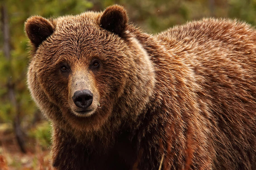

In [18]:
#@ INSPECTING THE IMAGES: 
dest = Path("./images")                      # Initializing Destination for Images. 
if dest.exists():                            # Inspecting Destination. 
    os.remove(dest)
download_url(urls[0], dest)                  # Downloading the Images. 
img = Image.open(dest)                       # Inspecting the Image. 
img.thumbnail((256, 256))                    # Inspecting the Image. 
img